# Clustering

## Imports

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import cdist
import umap.umap_ as umap

## Goal

In this file, we will create a visualization of the companies in our dataset following a clustering procedure.

In [67]:
df = pd.read_csv('Final_company_aspect_matrix_with_counts.csv')

## Preparing necessary columns

In [68]:
# Create sentiment weighted score to cluster companies
df["sentiment_weighted"] = df["avg_star_rating"] * df["n_mentions"]

# total reviews each firm received (across all aspects)
firm_totals = df.groupby("firm")["n_mentions"].sum()

# proportion of all mentions that are for this aspect
df["share"] = df["n_mentions"] / df["firm"].map(firm_totals)

# combine with sentiment to normalize:
df["sentiment_share"] = df["avg_star_rating"] * df["share"]

# Build the full matrix of aspect scoring ("sentiment share") per firm
matrix  = df.pivot_table(index="firm", columns="aspect", values="sentiment_share").fillna(0)

In [69]:
df.head()

,firm,aspect,avg_star_rating,n_mentions,sentiment_weighted,share,sentiment_share
0,AFH Wealth Management,culture,2.769231,13,36.0,0.076923,0.213018
1,AFH Wealth Management,growth & learning,3.444444,9,31.0,0.053254,0.183432
2,AFH Wealth Management,hr & recruitment,2.521739,23,58.0,0.136095,0.343195
3,AFH Wealth Management,job role clarity,1.000000,4,4.0,0.023669,0.023669
4,AFH Wealth Management,job security,1.400000,5,7.0,0.029586,0.041420


In [70]:
matrix.head()

aspect,culture,diversity & inclusion,growth & learning,hr & recruitment,job role clarity,job security,management,office & location,pay,people,performance feedback,perks & benefits,remote work,stress & pressure,teamwork & collaboration,tools & resources,work-life balance
firm,,,,,,,,,,,,,,,,,
AFH Wealth Management,0.213018,0.000000,0.183432,0.343195,0.023669,0.041420,0.337278,0.130178,0.213018,0.331361,0.029586,0.142012,0.000000,0.035503,0.213018,0.112426,0.224852
AJ Bell,0.287719,0.010526,0.387719,0.336842,0.029825,0.024561,0.201754,0.285965,0.268421,0.343860,0.040351,0.256140,0.022807,0.071930,0.178947,0.173684,0.156140
ASOS,0.301859,0.019322,0.258476,0.212906,0.048852,0.017864,0.143274,0.243164,0.170252,0.317536,0.027707,0.482319,0.005468,0.086766,0.148742,0.123223,0.216916
AXA UK,0.282517,0.071329,0.434965,0.254545,0.086713,0.020979,0.248951,0.149650,0.283916,0.367832,0.039161,0.353846,0.034965,0.025175,0.191608,0.265734,0.271329
Abcam,0.512195,0.023035,0.555556,0.176152,0.066396,0.013550,0.234417,0.340108,0.140921,0.468835,0.046070,0.201897,0.025745,0.177507,0.211382,0.186992,0.258808


In [71]:
print(matrix.shape)

(332, 17)


## Performing K-Means and Silhouette Score to find optimal number of clusters

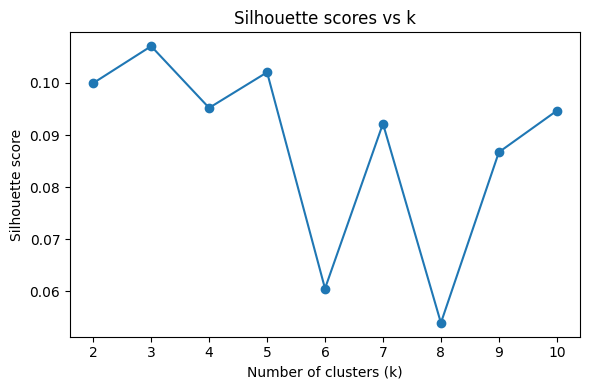

In [72]:
# Scale the matrix
scaler = StandardScaler()
X = scaler.fit_transform(matrix)

# Search over a range of k and record silhouette
silhouette_scores = {}
for k in range(2, 11):        
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = kmeans.fit_predict(X)
    silhouette_scores[k] = silhouette_score(X, labels)

# Convert to a DataFrame
sil_df = (pd.DataFrame(list(silhouette_scores.items()), columns=["k", "silhouette"]).sort_values("k").reset_index(drop=True))

# Visualise
plt.figure(figsize=(6, 4))
plt.plot(sil_df["k"], sil_df["silhouette"], marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette score")
plt.title("Silhouette scores vs k")
plt.tight_layout()
plt.show()

# Optional – fit the *best* model and attach labels to the original matrix
# best_k = sil_df.loc[sil_df["silhouette"].idxmax(), "k"]
# best_kmeans = KMeans(n_clusters=int(best_k), n_init=10, random_state=42)
# matrix["cluster"] = best_kmeans.fit_predict(X)

# Save or inspect `matrix` if you want:
# matrix.to_csv("/mnt/data/company_clusters.csv")

In [73]:
sil_df.head()

,k,silhouette
0,2,0.099976
1,3,0.107073
2,4,0.095217
3,5,0.102053
4,6,0.060512


### Inspecting this result: why is only 2 clusters the optimal number?

In [74]:
kmeans2 = KMeans(n_clusters=2, n_init=30, random_state=0).fit(X)
labels, counts = np.unique(kmeans2.labels_, return_counts=True)
print(dict(zip(labels, counts)))

outlier_idx = np.where(kmeans2.labels_ == 1)[0][0]
outlier_firm = matrix.index[outlier_idx]
print("Outlier firm:", outlier_firm)

# Quick look at its profile
display(matrix.loc[outlier_firm].sort_values(ascending=False).head())

{0: 161, 1: 171}
Outlier firm: AJ Bell


aspect
growth & learning    0.387719
people               0.343860
hr & recruitment     0.336842
culture              0.287719
office & location    0.285965
Name: AJ Bell, dtype: float64

<span style="color: red;"> Outlier detected! Ryan LLC has only two aspects detected with star rating equal to 5 and number of mentions equal to 1.</span>

### Solution: filter dataframe for n_mentions >= threshold

In [75]:
MIN_MENTIONS = 10 #Threshold

firm_totals = df.groupby("firm")["n_mentions"].transform("sum")
mask = firm_totals >= MIN_MENTIONS
df_filtered = df[mask].copy()

print(f"Dropped {len(df) - len(df_filtered)} firms "
      f"(< {MIN_MENTIONS} mentions); {df_filtered['firm'].nunique()} remain.")

Dropped 22 firms (< 10 mentions); 325 remain.


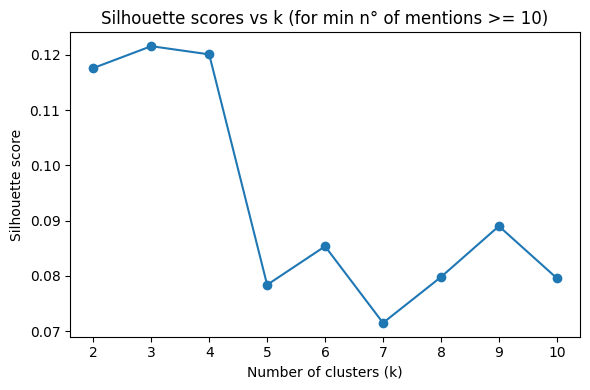

Silhouette scores: {2: 0.1176164913934094, 3: 0.12157274595731817, 4: 0.12008601367244177, 5: 0.07838800483297628, 6: 0.08535558816672838, 7: 0.07150061572081717, 8: 0.07979553765258843, 9: 0.08900828447214462, 10: 0.0795932888877011}
Best k = 3


In [76]:
# K-MEANS on filtered df
firm_totals_filtered = df_filtered.groupby("firm")["n_mentions"].transform("sum")
df_filtered["share"] = df_filtered["n_mentions"] / firm_totals_filtered
df_filtered["sentiment_share"] = (
        df_filtered["avg_star_rating"] * df_filtered["share"])

M_share = (df_filtered.pivot_table(index="firm", columns="aspect",values="sentiment_share").fillna(0))

# Silhouette loop
X = StandardScaler().fit_transform(M_share)
silhouette_scores = {}
for k in range(2, 11):        
    kmeans = KMeans(n_clusters=k, n_init=30, random_state=0)
    labels = kmeans.fit_predict(X)
    silhouette_scores[k] = silhouette_score(X, labels)

# Convert to a DataFrame
sil_df = (pd.DataFrame(list(silhouette_scores.items()), columns=["k", "silhouette"]).sort_values("k").reset_index(drop=True))

# Visualise
plt.figure(figsize=(6, 4))
plt.plot(sil_df["k"], sil_df["silhouette"], marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette score")
plt.title("Silhouette scores vs k (for min n° of mentions >= 10)")
plt.tight_layout()
plt.show()
print("Silhouette scores:", silhouette_scores)
best_k = max(silhouette_scores, key=silhouette_scores.get)
print("Best k =", best_k)

## Clustering strategy 1: VARIANCE

In [77]:
STRATEGY = "variance"      
N_KEEP   = 3               # how many aspects to keep

# Pick columns based on strategy
if STRATEGY == "variance":
    variances = M_share.var().sort_values(ascending=False)
    cols = variances.head(N_KEEP).index

elif STRATEGY == "mentions":
    total_mentions = (
        df_filtered.groupby("aspect")["n_mentions"].sum()
        .sort_values(ascending=False)
    )
    cols = total_mentions.head(N_KEEP).index

elif STRATEGY == "manual":
    cols = ["pay", "work-life balance","culture"]
else:
    raise ValueError("STRATEGY must be variance, mentions, or manual")

print(f"Keeping {len(cols)} aspects:\n", list(cols))

X_sel = M_share[cols]

Keeping 3 aspects:
 ['growth & learning', 'culture', 'people']


/Users/mariecieslar/miniforge3/envs/nlp/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/mariecieslar/miniforge3/envs/nlp/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


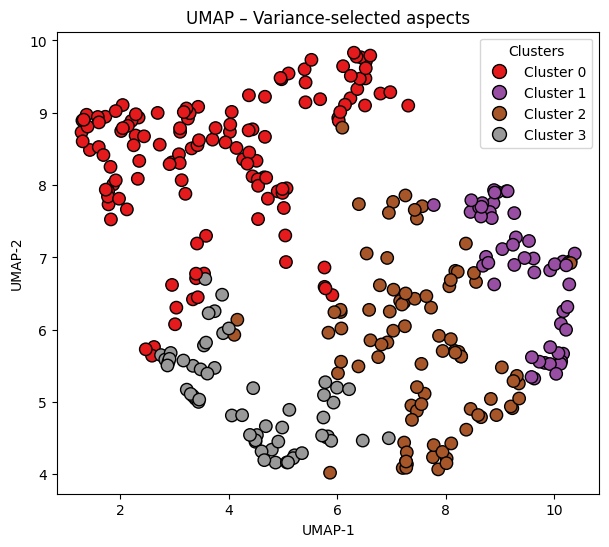

In [78]:
# Plot variance clusters 
X_scaled = StandardScaler().fit_transform(X_sel)
clust = AgglomerativeClustering(n_clusters=4, linkage="ward").fit(X_scaled) #adjust number of clusters
labels = clust.labels_
emb = umap.UMAP(random_state=42).fit_transform(X_scaled)

plt.figure(figsize=(7,6))
scatter = plt.scatter(emb[:,0], emb[:,1],
                      c=labels, cmap="Set1",
                      edgecolor="k", s=80)

unique = sorted(set(labels))
handles = [ plt.Line2D([], [], marker='o', linestyle='',
                       markerfacecolor=scatter.cmap(scatter.norm(lab)),
                       markeredgecolor='k', markersize=10,
                       label=f"Cluster {lab}")
            for lab in unique ]
plt.legend(handles=handles, title="Clusters", frameon=True)

plt.title(f"UMAP – {STRATEGY.capitalize()}‑selected aspects")
plt.xlabel("UMAP‑1"); plt.ylabel("UMAP‑2")
plt.show()

### Inspecting VARIANCE clusters

In [79]:
# Average value of each aspect per cluster
clusters = X_sel.copy()
clusters["cluster"] = labels      
profile = (
    clusters.groupby("cluster")
            .mean()               
            .round(2)
            .sort_index()
)
print(profile)

aspect   growth & learning  culture  people
cluster                                    
0                     0.23     0.21    0.29
1                     0.39     0.46    0.49
2                     0.41     0.32    0.34
3                     0.42     0.19    0.23


- Winners:
    - Best "people" --> cluster 1
    - Best "growth & learning" --> cluster 3
    - Best "work-life balance" --> cluster 0
- Loser:
    - Cluster 2

In [80]:
sizes = clusters["cluster"].value_counts().sort_index()
print("\nCluster sizes:\n", sizes, "\n")

for cl in sorted(clusters["cluster"].unique()):
    print(f"🟢 Cluster {cl} • {sizes.loc[cl]} firms")
    print(", ".join(clusters.query("cluster == @cl").index[:10]), "…\n")


Cluster sizes:
 cluster
0    128
1     52
2     88
3     57
Name: count, dtype: int64 

🟢 Cluster 0 • 128 firms
AFH Wealth Management, Active Care Group, Adecco, Age UK The National Charity, Angard Staffing, Animal and Plant Health Agency, Arcadia, Arnold Clark, Aviva, B and M Retail …

🟢 Cluster 1 • 52 firms
Abcam, ActionCOACH, AlixPartners, Apple, Bain and Company, Barnet and Chase Farm Hospitals NHS Trust, Barnett Waddingham, Bayer, Boston Consulting Group, Brewin Dolphin …

🟢 Cluster 2 • 88 firms
AJ Bell, ASOS, AXA UK, Accenture, American Express, Anglian Water, Anglo American, Aon, AstraZeneca, BAT …

🟢 Cluster 3 • 57 firms
Accor, Achieving for Children, Amey, Babcock International Group, Balfour Beatty, Barratt Developments, CBRE, CVS Group, Career Legal, Civil Service United Kingdom …



In [81]:
X_sel

aspect,growth & learning,culture,people
firm,,,
AFH Wealth Management,0.183432,0.213018,0.331361
AJ Bell,0.387719,0.287719,0.343860
ASOS,0.258476,0.301859,0.317536
AXA UK,0.434965,0.282517,0.367832
Abcam,0.555556,0.512195,0.468835
...,...,...,...
YOOX NET A PORTER GROUP,0.201306,0.213275,0.272035
ibis,0.367925,0.245283,0.292453
mydentist UK,0.330508,0.097458,0.173729


/var/folders/d7/grxt144d6wz6r6mqxx6jmqwm0000gn/T/ipykernel_35788/1260204782.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  customcmap = cm.get_cmap("Set1", len(labels_unique))


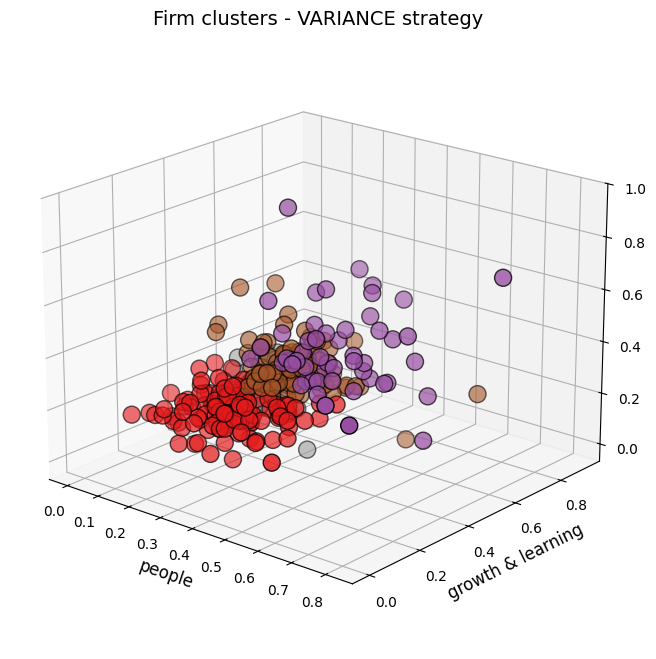

In [82]:
# 3‑D scatter of firms on (people, growth&learning, work-life balance)

# 1) Grab the three columns in the right order
axes = ["people", "growth & learning", "culture"]
xyz  = X_sel[axes].values                  

# 2) Make sure labels start at 0 for colormap indexing
labels_unique = np.unique(labels)
label_map     = {old: i for i, old in enumerate(labels_unique)}
color_labels  = np.vectorize(label_map.get)(labels)

customcmap = cm.get_cmap("Set1", len(labels_unique))

# 3) Plot
fig = plt.figure(figsize=(12, 8))
ax  = fig.add_subplot(111, projection="3d")

ax.scatter(
    xyz[:, 0], xyz[:, 1], xyz[:, 2],
    c=color_labels.astype(float),
    cmap=customcmap,
    s=150, edgecolor="k")

ax.set_xlabel("people", fontsize=12)
ax.set_ylabel("growth & learning", fontsize=12)
ax.set_zlabel("culture", fontsize=12, labelpad=10)
ax.view_init(20, -50)
ax.set_title("Firm clusters - VARIANCE strategy", fontsize=14)
plt.show()

## Clustering strategy 2: MANUAL

In [83]:
STRATEGY = "manual"      
N_KEEP   = 3               # how many aspects to keep

# Pick columns based on strategy
if STRATEGY == "variance":
    variances = M_share.var().sort_values(ascending=False)
    cols = variances.head(N_KEEP).index

elif STRATEGY == "mentions":
    total_mentions = (
        df_filtered.groupby("aspect")["n_mentions"].sum()
        .sort_values(ascending=False)
    )
    cols = total_mentions.head(N_KEEP).index

elif STRATEGY == "manual":
    cols = ["pay", "work-life balance","growth & learning"]
else:
    raise ValueError("STRATEGY must be variance, mentions, or manual")

print(f"Keeping {len(cols)} aspects:\n", list(cols))

X_sel = M_share[cols]

Keeping 3 aspects:
 ['pay', 'work-life balance', 'growth & learning']


/Users/mariecieslar/miniforge3/envs/nlp/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/mariecieslar/miniforge3/envs/nlp/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


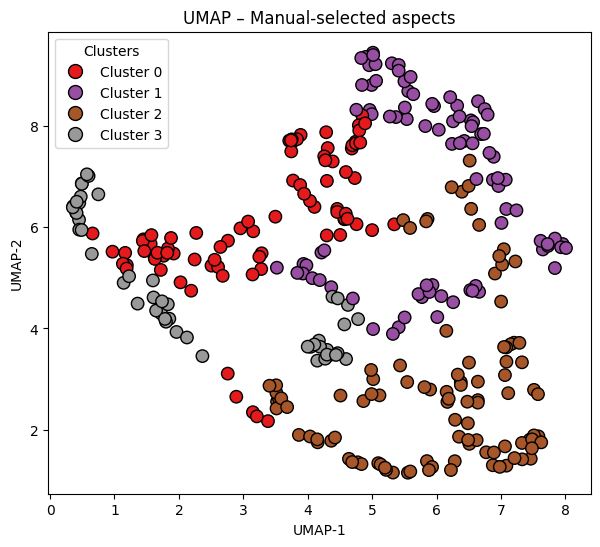

In [84]:
# Plot MANUAL clusters 
X_scaled = StandardScaler().fit_transform(X_sel)
clust = AgglomerativeClustering(n_clusters=4, linkage="ward").fit(X_scaled) #adjust number of clusters
labels = clust.labels_
emb = umap.UMAP(random_state=42).fit_transform(X_scaled)

plt.figure(figsize=(7,6))
scatter = plt.scatter(emb[:,0], emb[:,1],
                      c=labels, cmap="Set1",
                      edgecolor="k", s=80)

unique = sorted(set(labels))
handles = [ plt.Line2D([], [], marker='o', linestyle='',
                       markerfacecolor=scatter.cmap(scatter.norm(lab)),
                       markeredgecolor='k', markersize=10,
                       label=f"Cluster {lab}")
            for lab in unique ]
plt.legend(handles=handles, title="Clusters", frameon=True)

plt.title(f"UMAP – {STRATEGY.capitalize()}‑selected aspects")
plt.xlabel("UMAP‑1"); plt.ylabel("UMAP‑2")
plt.show()

### Inspecting MANUAL clusters

In [85]:
# Average value of each aspect per cluster
clusters = X_sel.copy()
clusters["cluster"] = labels      
profile = (
    clusters.groupby("cluster")
            .mean()               
            .round(2)
            .sort_index()
)
print(profile)

aspect    pay  work-life balance  growth & learning
cluster                                            
0        0.26               0.42               0.38
1        0.28               0.22               0.45
2        0.21               0.24               0.25
3        0.44               0.33               0.26


- Winners:
    - Best "pay" --> cluster 0
    - Best "work-life balance" --> cluster 1
    - Best "culture" --> cluster 2
- Loser:
    - Cluster 3

In [86]:
sizes = clusters["cluster"].value_counts().sort_index()
print("\nCluster sizes:\n", sizes, "\n")

for cl in sorted(clusters["cluster"].unique()):
    print(f"🟢 Cluster {cl} • {sizes.loc[cl]} firms")
    print(", ".join(clusters.query("cluster == @cl").index[:10]), "…\n")


Cluster sizes:
 cluster
0     83
1     90
2    102
3     50
Name: count, dtype: int64 

🟢 Cluster 0 • 83 firms
American Express, Angard Staffing, Animal and Plant Health Agency, Aon, AstraZeneca, BBC, BDO, BNP Paribas, BNY Mellon, BP …

🟢 Cluster 1 • 90 firms
AJ Bell, AXA UK, Abcam, Accenture, Accor, Achieving for Children, ActionCOACH, AlixPartners, Amey, Anglian Water …

🟢 Cluster 2 • 102 firms
AFH Wealth Management, ASOS, Age UK The National Charity, Apple, Arcadia, Aviva, B and M Retail, BHS, BPP Holdings, Babylon Health …

🟢 Cluster 3 • 50 firms
Active Care Group, Adecco, Arnold Clark, B and Q, Blue Arrow, Brook Street, CVS Group, Co op, DFS Furniture, DHL Supply Chain …



/var/folders/d7/grxt144d6wz6r6mqxx6jmqwm0000gn/T/ipykernel_35788/3065673111.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  customcmap = cm.get_cmap("Set1", len(labels_unique))


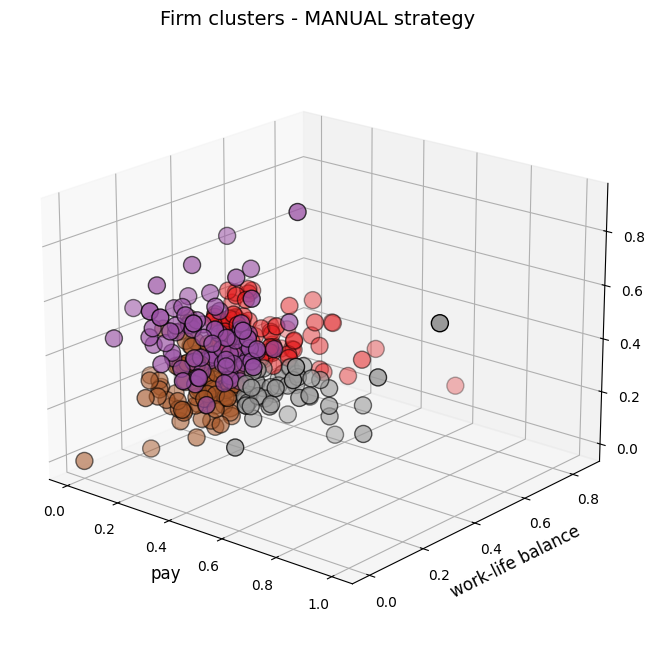

In [87]:
# 3‑D scatter of firms on (pay, work-life balance, culture)

# 1) Grab the three columns in the right order
axes = ["pay", "work-life balance", "growth & learning"]
xyz  = X_sel[axes].values                  

# 2) Make sure labels start at 0 for colormap indexing
labels_unique = np.unique(labels)
label_map     = {old: i for i, old in enumerate(labels_unique)}
color_labels  = np.vectorize(label_map.get)(labels)

customcmap = cm.get_cmap("Set1", len(labels_unique))

# 3) Plot
fig = plt.figure(figsize=(12, 8))
ax  = fig.add_subplot(111, projection="3d")

ax.scatter(
    xyz[:, 0], xyz[:, 1], xyz[:, 2],
    c=color_labels.astype(float),
    cmap=customcmap,
    s=150, edgecolor="k")

ax.set_xlabel("pay", fontsize=12)
ax.set_ylabel("work-life balance", fontsize=12)
ax.set_zlabel("growth & learning", fontsize=12, labelpad=10)
ax.view_init(20, -50)
ax.set_title("Firm clusters - MANUAL strategy", fontsize=14)
plt.show()

## Clustering strategy 3: MENTIONS

In [88]:
STRATEGY = "mentions"      
N_KEEP   = 3               # how many aspects to keep

# Pick columns based on strategy
if STRATEGY == "variance":
    variances = M_share.var().sort_values(ascending=False)
    cols = variances.head(N_KEEP).index

elif STRATEGY == "mentions":
    total_mentions = (
        df_filtered.groupby("aspect")["n_mentions"].sum()
        .sort_values(ascending=False)
    )
    cols = total_mentions.head(N_KEEP).index

elif STRATEGY == "manual":
    cols = ["pay", "work-life balance","culture"]
else:
    raise ValueError("STRATEGY must be variance, mentions, or manual")

print(f"Keeping {len(cols)} aspects:\n", list(cols))

X_sel = M_share[cols]

Keeping 3 aspects:
 ['pay', 'growth & learning', 'work-life balance']


/Users/mariecieslar/miniforge3/envs/nlp/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/mariecieslar/miniforge3/envs/nlp/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


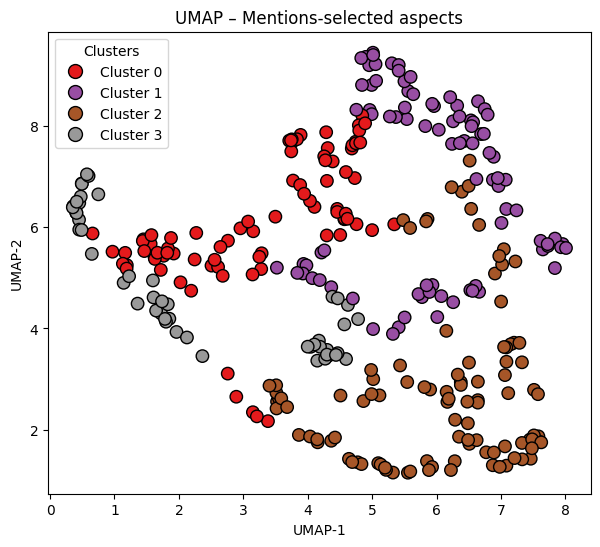

In [89]:
# Plot mentions clusters 
X_scaled = StandardScaler().fit_transform(X_sel)
clust = AgglomerativeClustering(n_clusters=4, linkage="ward").fit(X_scaled) #adjust number of clusters
labels = clust.labels_
emb = umap.UMAP(random_state=42).fit_transform(X_scaled)

plt.figure(figsize=(7,6))
scatter = plt.scatter(emb[:,0], emb[:,1],
                      c=labels, cmap="Set1",
                      edgecolor="k", s=80)

unique = sorted(set(labels))
handles = [ plt.Line2D([], [], marker='o', linestyle='',
                       markerfacecolor=scatter.cmap(scatter.norm(lab)),
                       markeredgecolor='k', markersize=10,
                       label=f"Cluster {lab}")
            for lab in unique ]
plt.legend(handles=handles, title="Clusters", frameon=True)

plt.title(f"UMAP – {STRATEGY.capitalize()}‑selected aspects")
plt.xlabel("UMAP‑1"); plt.ylabel("UMAP‑2")
plt.show()

### Inspecting MENTIONS Clusters

In [90]:
# Average value of each aspect per cluster
clusters = X_sel.copy()
clusters["cluster"] = labels      
profile = (
    clusters.groupby("cluster")
            .mean()               
            .round(2)
            .sort_index()
)
print(profile)

aspect    pay  growth & learning  work-life balance
cluster                                            
0        0.26               0.38               0.42
1        0.28               0.45               0.22
2        0.21               0.25               0.24
3        0.44               0.26               0.33


- Winners:
    - Best "pay" --> cluster 2
    - Best "work-life balance" --> cluster 1
    - Best "growth & learning" --> cluster 3
- Loser:
    - Cluster 0

In [91]:
sizes = clusters["cluster"].value_counts().sort_index()
print("\nCluster sizes:\n", sizes, "\n")

for cl in sorted(clusters["cluster"].unique()):
    print(f"🟢 Cluster {cl} • {sizes.loc[cl]} firms")
    print(", ".join(clusters.query("cluster == @cl").index[:10]), "…\n")


Cluster sizes:
 cluster
0     83
1     90
2    102
3     50
Name: count, dtype: int64 

🟢 Cluster 0 • 83 firms
American Express, Angard Staffing, Animal and Plant Health Agency, Aon, AstraZeneca, BBC, BDO, BNP Paribas, BNY Mellon, BP …

🟢 Cluster 1 • 90 firms
AJ Bell, AXA UK, Abcam, Accenture, Accor, Achieving for Children, ActionCOACH, AlixPartners, Amey, Anglian Water …

🟢 Cluster 2 • 102 firms
AFH Wealth Management, ASOS, Age UK The National Charity, Apple, Arcadia, Aviva, B and M Retail, BHS, BPP Holdings, Babylon Health …

🟢 Cluster 3 • 50 firms
Active Care Group, Adecco, Arnold Clark, B and Q, Blue Arrow, Brook Street, CVS Group, Co op, DFS Furniture, DHL Supply Chain …



/var/folders/d7/grxt144d6wz6r6mqxx6jmqwm0000gn/T/ipykernel_35788/3337722419.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  customcmap = cm.get_cmap("Set1", len(labels_unique))


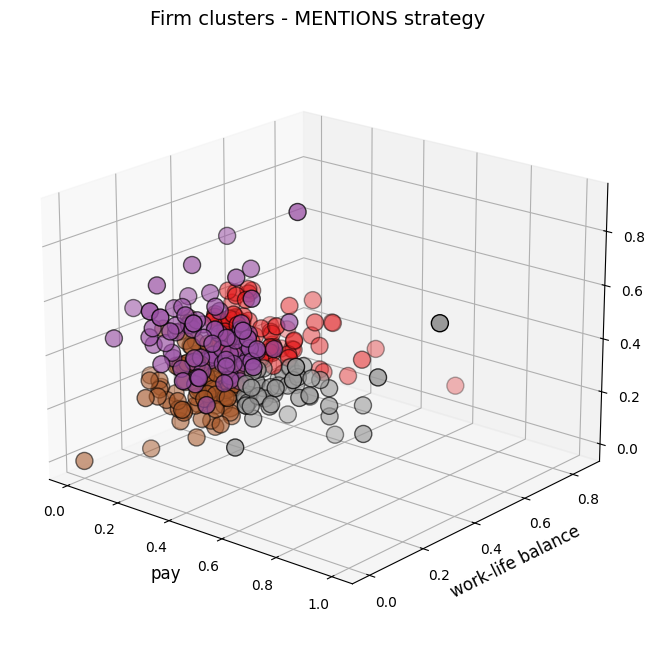

In [92]:
# 3‑D scatter of firms on (pay, work-life balance, growth & learning)

# 1) Grab the three columns in the right order
axes = ["pay", "work-life balance", "growth & learning"]
xyz  = X_sel[axes].values                  

# 2) Make sure labels start at 0 for colormap indexing
labels_unique = np.unique(labels)
label_map     = {old: i for i, old in enumerate(labels_unique)}
color_labels  = np.vectorize(label_map.get)(labels)

customcmap = cm.get_cmap("Set1", len(labels_unique))

# 3) Plot
fig = plt.figure(figsize=(12, 8))
ax  = fig.add_subplot(111, projection="3d")

ax.scatter(
    xyz[:, 0], xyz[:, 1], xyz[:, 2],
    c=color_labels.astype(float),
    cmap=customcmap,
    s=150, edgecolor="k")

ax.set_xlabel("pay", fontsize=12)
ax.set_ylabel("work-life balance", fontsize=12)
ax.set_zlabel("growth & learning", fontsize=12, labelpad=10)
ax.view_init(20, -50)
ax.set_title("Firm clusters - MENTIONS strategy", fontsize=14)
plt.show()